## Assignment: predicting house prices and examining results on test data

In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Split your data into train and test sets.
 - #### [done](#split_data)
 
1. Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
 - #### [done](#access_fit_predict)
1. Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
 - #### [done](#access_fit_predict)
1. Is the performance of your model satisfactory? Why?
 - for MAE, I want a lower value, the current value I have seems high, but I can't ge sure unless I tweak the model and have something to compare it against.
1. Try to improve your model in terms of predictive performance by adding or removing some variables.
 - [I removed the categorical features of the neighborhoods from the model.  This caused the MAE to rise from 22661 to 28400.  This was not advantageous since I want a smaller mean absolute error.](#adj_1)
 - [I only included two features, overall quality & overall condition.  This caused the mean absolute error to increase to 33876. Clearly, this was not a desirable result](#adj_2)
 - [When selecting only categorical features - 'neighborhood', 'lotconfig', 'condition1', 'exterqual' - the model did slightly better than above with a mean absolute error of 31298.](#adj_3)
 

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn import linear_model

import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)

pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [4]:
house_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [5]:
# this dataset has a huge number of columns
house_prices.shape

(1460, 81)

In [7]:
# numerical features I'm interested in
house_features = house_prices[[x.lower() for x in ['OverallQual',
                                                    'OverallCond', 
                                                    'GrLivArea',
                                                    'bedroomabvgr'
                                                    ]]].copy()

In [8]:
# combine numerical columns above with 
# categorical feature neighborhood converted to numerical
pd.concat([house_features, pd.get_dummies(house_prices.neighborhood)], axis=1).head()

,overallqual,overallcond,grlivarea,bedroomabvgr,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,7,5,1710,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,8,1262,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7,5,1786,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,5,1717,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,5,2198,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [10]:
# assign X and Y variables

# Y is the target variable
Y = house_prices.saleprice
# X is the feature set which includes
X = pd.concat([house_features, pd.get_dummies(house_prices.neighborhood)], axis=1)

<a id="split_data"></a>

### Split data to be able to test the model on data it hasn't seen before

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [15]:
# add a constant to the model, the “baseline” 
# of the data in case all of your features values are 0.

X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# show the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     150.0
Date:                Wed, 13 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:18:45   Log-Likelihood:                -13906.
No. Observations:                1168   AIC:                         2.787e+04
Df Residuals:                    1139   BIC:                         2.802e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.567e+04   8837.482     -4.036   

<a id="access_fit_predict"></a>

### Access fit and predict

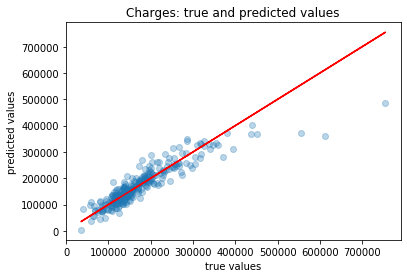

Mean absolute error of the prediction is: 22661.25235154799
Mean squared error of the prediction is: 1313792868.1810868
Root mean squared error of the prediction is: 36246.28074963122
Mean absolute percentage error of the prediction is: 13.765351471653906


In [19]:
# We add constant to the model as it's a best practice
# to do so every time
X_test = sm.add_constant(X_test)

# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds, alpha=.3)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

<a id="adj_1"></a>

### Adjustment 1 - Exclude neighborhood features from my model, then compare results

In [37]:
house_features.head()

,overallqual,overallcond,grlivarea,bedroomabvgr
0,7,5,1710,3
1,6,8,1262,3
2,7,5,1786,3
3,7,5,1717,3
4,8,5,2198,4


In [40]:
# assign X and Y variables

# Y is the target variable
Y = house_prices.saleprice
# X is the feature set which includes
X = house_features

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [42]:
# add a constant to the model, the “baseline” 
# of the data in case all of your features values are 0.

X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# show the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     722.8
Date:                Wed, 13 Nov 2019   Prob (F-statistic):          1.77e-313
Time:                        16:23:26   Log-Likelihood:                -14078.
No. Observations:                1168   AIC:                         2.817e+04
Df Residuals:                    1163   BIC:                         2.819e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.586e+04   9574.117     -7.924   

<a id="access_fit_predict"></a>

### Access fit and predict

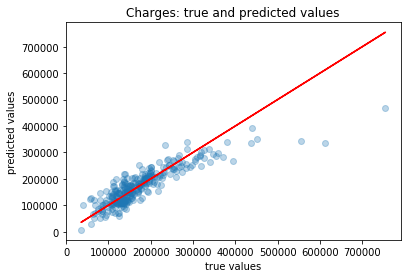

Mean absolute error of the prediction is: 28400.207916766805
Mean squared error of the prediction is: 1802171386.6205504
Root mean squared error of the prediction is: 42451.98919509604
Mean absolute percentage error of the prediction is: 17.97266614581189


In [43]:
# We add constant to the model as it's a best practice
# to do so every time
X_test = sm.add_constant(X_test)

# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds, alpha=.3)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

<a id="adj_2"></a>
### Adjustment 2 - Only use overall quality & overall condition

Exclude the insignificant features from my model

In [37]:
house_features.head()

,overallqual,overallcond,grlivarea,bedroomabvgr
0,7,5,1710,3
1,6,8,1262,3
2,7,5,1786,3
3,7,5,1717,3
4,8,5,2198,4


In [47]:
# select features
house_features.iloc[:,0:2].head()

,overallqual,overallcond
0,7,5
1,6,8
2,7,5
3,7,5
4,8,5


In [48]:
house_features = house_features.iloc[:,0:2]

In [49]:
# assign X and Y variables

# Y is the target variable
Y = house_prices.saleprice
# X is the feature set which includes
X = house_features

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [51]:
# add a constant to the model, the “baseline” 
# of the data in case all of your features values are 0.

X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# show the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     955.2
Date:                Wed, 13 Nov 2019   Prob (F-statistic):          2.73e-246
Time:                        16:31:15   Log-Likelihood:                -14241.
No. Observations:                1168   AIC:                         2.849e+04
Df Residuals:                    1165   BIC:                         2.850e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.156e+04   9884.613     -9.263      

<a id="access_fit_predict"></a>

### Access fit and predict

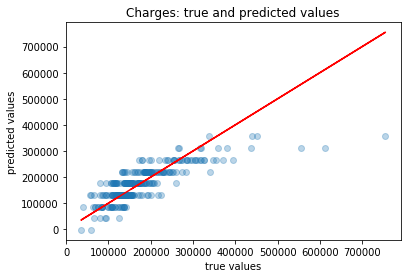

Mean absolute error of the prediction is: 33876.020924539625
Mean squared error of the prediction is: 2689723737.585781
Root mean squared error of the prediction is: 51862.54657829464
Mean absolute percentage error of the prediction is: 21.47413544176038


In [52]:
# We add constant to the model as it's a best practice
# to do so every time
X_test = sm.add_constant(X_test)

# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds, alpha=.3)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

<a id="adj_3"></a>
### Adjustment 3 - different categorical features

In [58]:
house_prices.exterqual.value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: exterqual, dtype: int64

In [56]:
house_prices.condition1.value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: condition1, dtype: int64

In [54]:
house_prices.lotconfig.value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: lotconfig, dtype: int64

In [53]:
house_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [81]:
pd.get_dummies(house_prices['neighborhood'])

,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1457,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1458,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
# 'neighborhood', 'lotconfig', 'condition1', 'exterqual'

pd.concat((pd.get_dummies(house_prices.neighborhood),
         pd.get_dummies(house_prices.lotconfig),
         pd.get_dummies(house_prices.condition1),
         pd.get_dummies(house_prices.exterqual)), axis=1).head()

# pd.concat([house_features, pd.get_dummies(house_prices.neighborhood)], axis=1).head()

,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Corner,CulDSac,FR2,FR3,Inside,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Ex,Fa,Gd,TA
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [78]:
# select categorical columns
pd.get_dummies(data=house_prices, columns=['neighborhood', 'lotconfig', 'condition1', 'exterqual'], drop_first=True).head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,landslope,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,exterqual_Fa,exterqual_Gd,exterqual_TA
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Gtl,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,Gtl,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Gtl,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Gtl,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,Gtl,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


In [97]:
# assign X and Y variables

# Y is the target variable
Y = house_prices.saleprice
# X is the feature set which includes
X = pd.concat((pd.get_dummies(house_prices.neighborhood),
         pd.get_dummies(house_prices.lotconfig),
         pd.get_dummies(house_prices.condition1),
         pd.get_dummies(house_prices.exterqual)), axis=1)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [99]:
# add a constant to the model, the “baseline” 
# of the data in case all of your features values are 0.

X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# show the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     50.65
Date:                Wed, 13 Nov 2019   Prob (F-statistic):          1.21e-217
Time:                        17:05:22   Log-Likelihood:                -14217.
No. Observations:                1168   AIC:                         2.851e+04
Df Residuals:                    1128   BIC:                         2.872e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.459e+17   2.97e+17     -0.492      0.6

<a id="access_fit_predict"></a>

### Access fit and predict

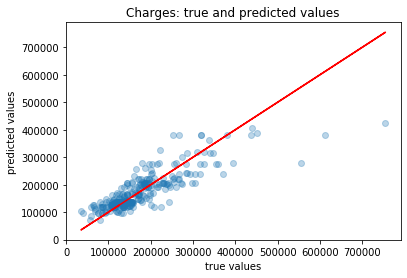

Mean absolute error of the prediction is: 31298.246575342466
Mean squared error of the prediction is: 2249147638.520548
Root mean squared error of the prediction is: 47425.17937257115
Mean absolute percentage error of the prediction is: 18.996155953822353


In [100]:
# We add constant to the model as it's a best practice
# to do so every time
X_test = sm.add_constant(X_test)

# make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds, alpha=.3)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

For lower value homes this model seemed to do well, but much less well for higher value homes.